In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e3/sample_submission.csv
/kaggle/input/playground-series-s3e3/train.csv
/kaggle/input/playground-series-s3e3/test.csv


# Import Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import skew
from xgboost import XGBRegressor
from datetime import datetime
from matplotlib.ticker import MaxNLocator

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s3e3/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e3/test.csv')

In [4]:
df

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,1672,30,Travel_Rarely,945,Sales,1,3,Life Sciences,1,4,...,80,0,10,2,4,10,0,0,8,0
1673,1673,32,Travel_Rarely,1303,Research & Development,2,3,Life Sciences,1,1,...,80,1,10,3,4,4,2,1,3,0
1674,1674,29,Travel_Frequently,1184,Human Resources,24,3,Human Resources,1,2,...,80,0,1,2,3,1,0,0,0,1
1675,1675,36,Travel_Rarely,441,Sales,9,2,Marketing,1,2,...,80,2,10,3,2,10,3,0,8,0


In [5]:
df = df.drop('id',axis=1)
test = test_df.drop('id',axis=1)

In [6]:
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,80,0,31,0,3,31,14,4,10,1


# EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1677 non-null   int64 
 1   BusinessTravel            1677 non-null   object
 2   DailyRate                 1677 non-null   int64 
 3   Department                1677 non-null   object
 4   DistanceFromHome          1677 non-null   int64 
 5   Education                 1677 non-null   int64 
 6   EducationField            1677 non-null   object
 7   EmployeeCount             1677 non-null   int64 
 8   EnvironmentSatisfaction   1677 non-null   int64 
 9   Gender                    1677 non-null   object
 10  HourlyRate                1677 non-null   int64 
 11  JobInvolvement            1677 non-null   int64 
 12  JobLevel                  1677 non-null   int64 
 13  JobRole                   1677 non-null   object
 14  JobSatisfaction         

In [8]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,36.036971,892.749553,8.683959,2.937984,1.0,2.757901,67.798450,2.782349,1.998807,2.791890,...,80.0,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643,0.119261
std,8.507112,374.496259,7.826143,1.039078,0.0,1.086835,19.435928,0.650664,1.083065,1.097396,...,0.0,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189,0.324192
min,18.000000,107.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,1.000000,...,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,589.000000,2.000000,2.000000,1.0,2.000000,51.000000,2.000000,1.000000,2.000000,...,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,35.000000,890.000000,7.000000,3.000000,1.0,3.000000,69.000000,3.000000,2.000000,3.000000,...,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,41.000000,1223.000000,12.000000,4.000000,1.0,4.000000,84.000000,3.000000,2.000000,4.000000,...,80.0,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000,0.000000
max,60.000000,3921.000000,29.000000,15.000000,1.0,4.000000,100.000000,4.000000,7.000000,4.000000,...,80.0,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000,1.000000


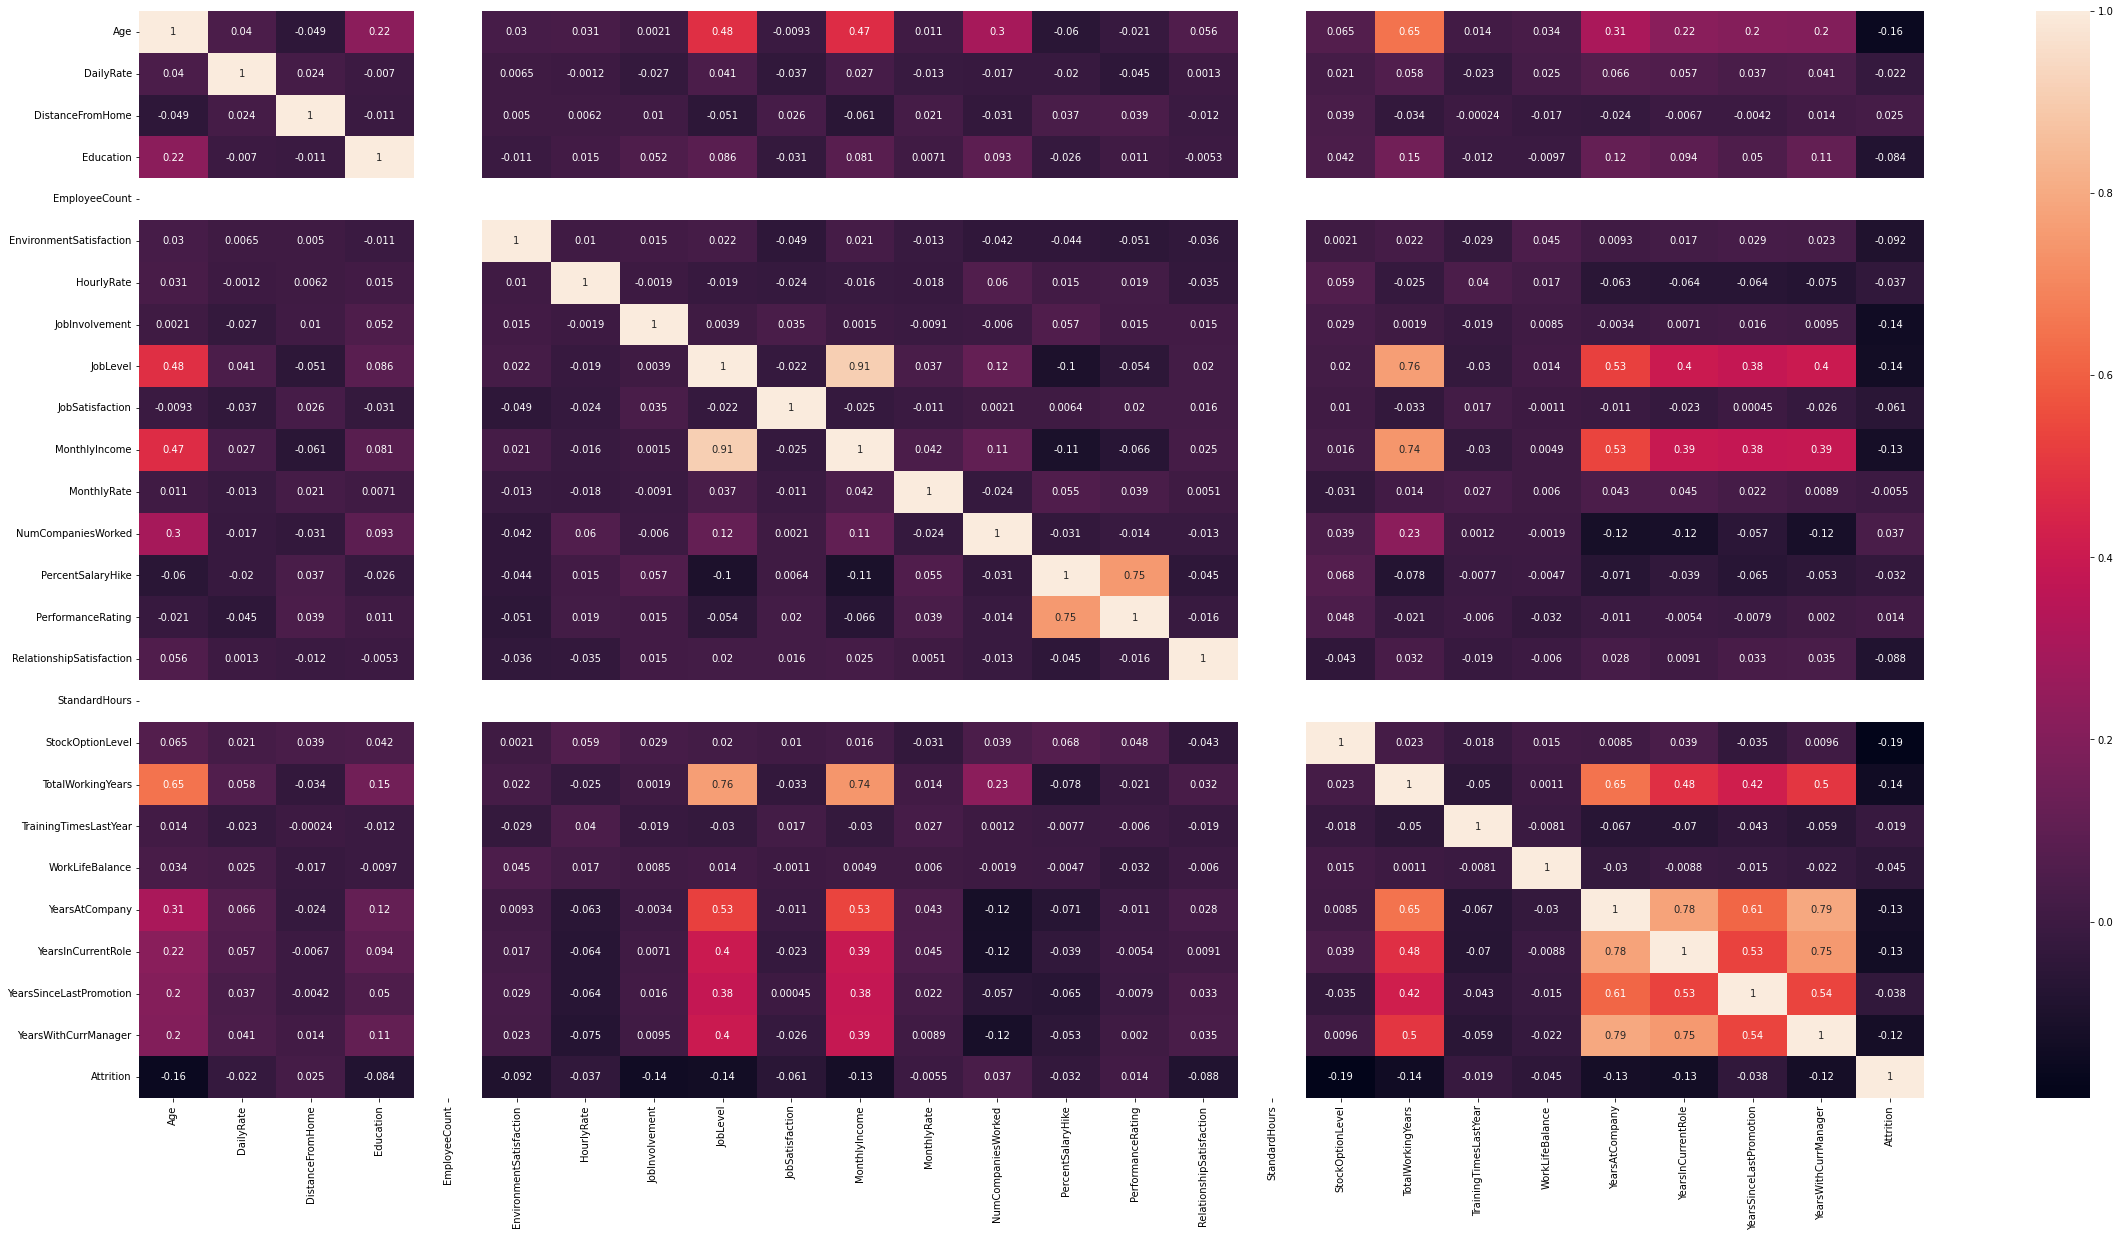

In [9]:
plt.figure(figsize=(40,20))
sns.heatmap(df.corr(),annot=True)
plt.show()

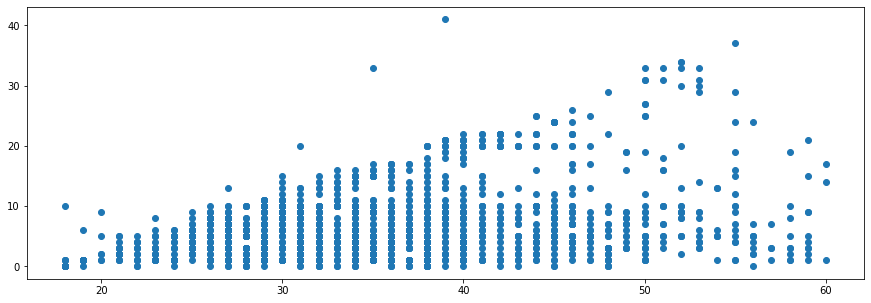

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
analys = df.loc[:,['Age','YearsAtCompany']]
ax.scatter(analys.Age,analys.YearsAtCompany)

In [11]:
feture = []
for i in df.columns:
    if df[i].dtypes != (object):
        feture.append(i)

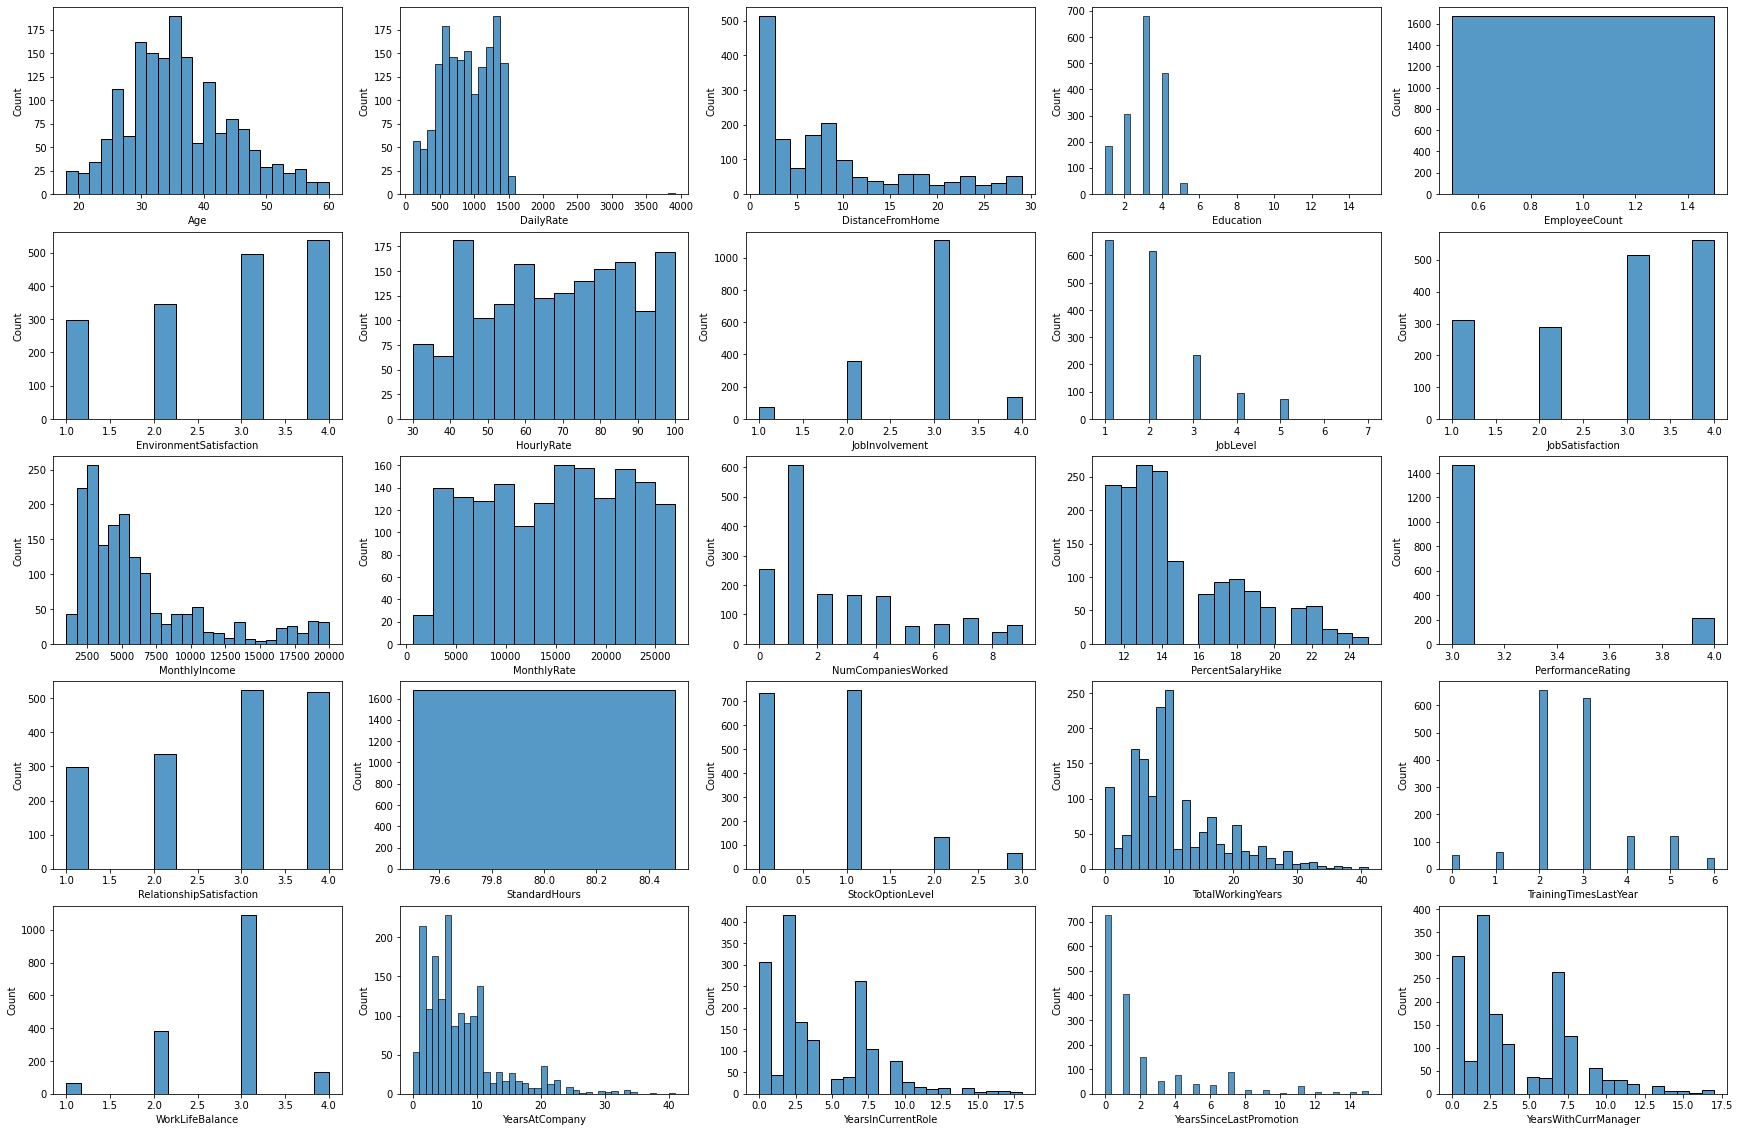

In [12]:
fig , axes = plt.subplots(5,5,figsize=(30,20))
for i ,j in zip(feture,axes.flatten()):
    sns.histplot(df[i],ax=j)
plt.show()

In [13]:
for i in df.columns:
    if df[i].dtypes != (object):
        pass
    else:
        print('*'*20)
        print(i)
        print('*'*20)
        print(df[i].unique())

********************
BusinessTravel
********************
['Travel_Frequently' 'Travel_Rarely' 'Non-Travel']
********************
Department
********************
['Research & Development' 'Sales' 'Human Resources']
********************
EducationField
********************
['Medical' 'Other' 'Marketing' 'Life Sciences' 'Technical Degree'
 'Human Resources']
********************
Gender
********************
['Male' 'Female']
********************
JobRole
********************
['Laboratory Technician' 'Sales Representative' 'Sales Executive'
 'Healthcare Representative' 'Manager' 'Manufacturing Director'
 'Research Scientist' 'Human Resources' 'Research Director']
********************
MaritalStatus
********************
['Married' 'Divorced' 'Single']
********************
Over18
********************
['Y']
********************
OverTime
********************
['Yes' 'No']


In [14]:
for i in df.columns[:-1]:
    if df[i].dtypes != (object):
        if (skew(df[i])>0.5) or (skew(df[i])<-0.5):
            df[i] = np.log1p(df[i])
            test[i] = np.log1p(test[i])

In [15]:
df = pd.get_dummies(df,columns=['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime'])
test = pd.get_dummies(test,columns=['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime'])

In [16]:
df.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,36,599,3.218876,1.386294,1,4,42,1.386294,0.693147,4,...,0,0,0,0,0,0,1,0,0,1
1,35,921,2.197225,1.386294,1,1,46,1.386294,0.693147,1,...,0,0,0,0,1,0,1,0,1,0
2,32,718,3.295837,1.386294,1,3,80,1.386294,1.098612,4,...,0,0,0,1,0,1,0,0,1,0
3,38,1488,1.098612,1.386294,1,3,40,1.386294,1.098612,1,...,0,0,0,0,0,0,1,0,1,0
4,50,1017,1.791759,1.609438,1,2,37,1.386294,1.791759,1,...,0,0,0,0,0,0,0,1,0,1


In [17]:
X = df.drop(['Attrition','Over18'],axis=1)
y = df['Attrition']
test = test.drop('Over18',axis=1)

In [18]:
from  sklearn.model_selection import train_test_split

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Data Preprocessing

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
sca = StandardScaler()

In [22]:
X_train = sca.fit_transform(X_train)
X_test = sca.fit_transform(X_test)
test = sca.fit_transform(test)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier,StackingClassifier
from xgboost import XGBClassifier
from lightgbm import  LGBMClassifier

# Model Fit Train

In [24]:
fold = StratifiedKFold(10)
Ran = RandomForestClassifier(bootstrap= True, max_depth=None, n_estimators=100)
Ran.fit(X_train,y_train)

RandomForestClassifier()

In [25]:
ada = AdaBoostClassifier(learning_rate = 0.3, n_estimators = 150)
ada.fit(X_train,y_train)

AdaBoostClassifier(learning_rate=0.3, n_estimators=150)

In [26]:
gbc = GradientBoostingClassifier(learning_rate=0.6,max_depth=6,n_estimators=600,random_state=None)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.6, max_depth=6, n_estimators=600)

In [27]:
lbg = LGBMClassifier(learning_rate = 0.25, max_depth = 1, n_estimators = 200)
lbg.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.25, max_depth=1, n_estimators=200)

In [28]:
xgb = XGBClassifier(colsample_bytree=0.6,
 learning_rate= 0.25,
 max_depth= 1,
 min_child_weight= 0,
 n_estimators= 200)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=0,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [29]:
models = [('random',Ran),('Adabosst',ada),('Gradiant',gbc),('Ligth',lbg),('XGb',xgb)]
StakingModel = StackingClassifier(estimators=models,cv=fold,n_jobs=-1)

In [30]:
StakingModel.fit(X_train,y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=10,
        random_state=RandomState(MT19937) at 0x7FB659303160, shuffle=False),
                   estimators=[('random', RandomForestClassifier()),
                               ('Adabosst',
                                AdaBoostClassifier(learning_rate=0.3,
                                                   n_estimators=150)),
                               ('Gradiant',
                                GradientBoostingClassifier(learning_rate=0.6,
                                                           max_depth=6,
                                                           n_estimators=600)),
                               ('Ligth',
                                LGBMClassifier(learnin...
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              inte

In [31]:
pred=StakingModel.predict_proba(test)[:,1]

# Submission

In [32]:
Output = pd.DataFrame({'id':test_df.id,'Attrition':pred})
Output.to_csv('Submision.csv',index=False)
Output.head()

,id,Attrition
0,1677,0.112832
1,1678,0.078394
2,1679,0.055168
3,1680,0.060949
4,1681,0.373779
